                                                  Class: Statistical Learning Methods, Warsaw School Of Economics
                                                  Date: 2021-05-31 [updates: 2022-11, 2024-12]
                                                  Author: Joanna Koła
                                                  Data: https://archive.ics.uci.edu/ml/dataset/Bank+Marketing


# Influence of marketing on term deposits subscriptions 

The dataset consists of the following attributes:

* ***Client personal information:*** age, job, marital status, education level
* ***Previous client credit history:*** if client has credit in default(default), housing loan(housing) or personal loan (loan)
* ***Related with the campaign:*** contact communication type (contact), last contact month of year(month), last contact day of the week (day_of_week), last contact duration (duration), number of contacts performed during this campaign and for this client(campaign), number of days that passed by after the client was last contacted from a previous campaign (pdays), number of contacts performed before this campaign (previous), outcome of the previous marketing campaign (poutcome)
* ***Social and economic context attributes:*** quarterly indicator of employment variation rate (emp.var.rate),  monthly indicator of consumer price index (cons.price.idx), consumer confidence index (cons.conf.idx), daily indicator of euribor 3 month rate (euribor3m), quarterly indicator of number of employees (nr.employed)
* ***Group flag*** - campaign group or control group

**The aim of the following analysis is to use machine learning to identify customers worth contacting in order to maximise the profits that the next wave of campaigns will bring.**

In [67]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import random
import warnings

from scipy import stats
#import scikitplot as skplt

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, RepeatedStratifiedKFold, train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import KNNImputer

from xgboost import XGBClassifier

import warnings
from typing import List, Union

warnings.filterwarnings("ignore")
random.seed(11)

sns.set_palette("tab10")

In [68]:
df = pd.read_csv('bank_data_prediction_task.csv', index_col=0)

# Informations about the campaign

* **the placement of deposits after campaign was 1.5 times higher than without it**
* **40% of clients were included in the campaign**

In [69]:
def show_categories_bar_chart(x, y, dataset):
    # Group and calculate percentages
    grouped_data = (
        dataset.groupby(x)[y]
        .value_counts(normalize=True)
        .mul(100)
        .rename('percent')
        .reset_index()
    )

    # Create the bar chart using seaborn
    sns.catplot(
        data=grouped_data,
        x=x,
        y='percent',
        hue=y,
        kind='bar',
        height=4,
        aspect=3
    )

    plt.show()

In [70]:
groups_counts = df['test_control_flag'].value_counts()

print("Total number of clients in control group: {}".format(groups_counts[0]))
print("Total number of clients in campaign group: {}".format(groups_counts[1]))
print("What percentage of clients is taken into campaign: {} %".format(
    round(groups_counts[1] / (groups_counts[0] + groups_counts[1]), 2) *100))

Total number of clients in control group: 24712
Total number of clients in campaign group: 16476
What percentage of clients is taken into campaign: 40.0 %


Percentage of clients in the campaign group who placed a deposit 15.08 %
Percentage of clients in the control group who placed a deposit 10.86 %


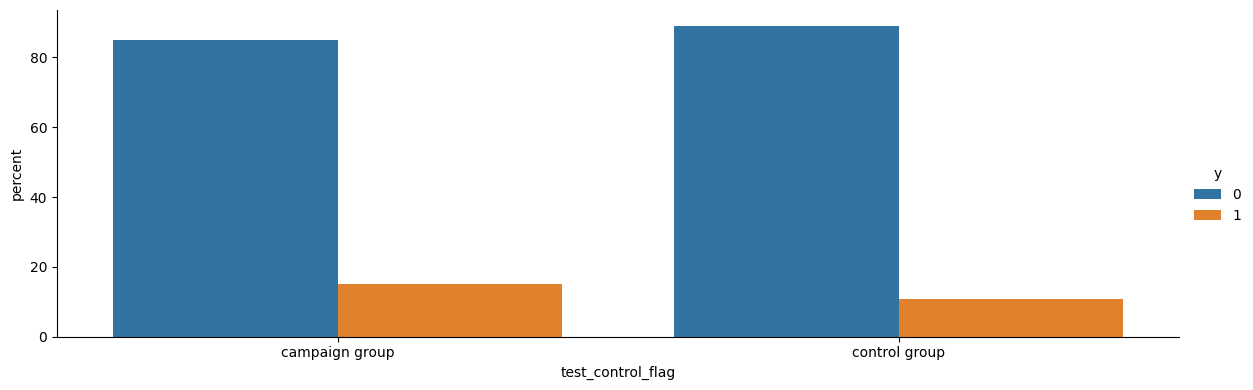

In [71]:
# changing y into 0-1 variable
df['y'].replace('yes', 1, inplace=True)
df['y'].replace('no', 0, inplace=True)

populations = [i[1] for i in df.groupby(["test_control_flag"])['y'].count().reset_index().values]
ys = [i[1] for i in df.groupby(["test_control_flag"])['y'].sum().reset_index().values]

print("Percentage of clients in the campaign group who placed a deposit {} %".
      format(round(ys[0] / populations[0] * 100, 2)))
print("Percentage of clients in the control group who placed a deposit {} %".
      format(round(ys[1] / populations[1] * 100, 2)))

show_categories_bar_chart('test_control_flag', 'y', df)

The aim of this analysis is to create a model that will be able to predict the success of future campaigns for a client. This means that ***only features that are known before the campaign might be used to build the model***. Features that can be only used during EDA to obtain some insights that could improve our campaign:

* contact communication type (***contact***), last contact month of year(**month**), last contact day of the week (**day_of_week**), last contact duration (**duration**), number of contacts performed during this campaign and for this client(**campaign**)

# Loking for missing values #

After looking for missing values, I have concluded that almost 3/4 of the dataset rows have missing values. Removing them in this case would be unacceptable. It will be necessary to deal with them in other ways.

In [72]:
print("Number of rows with missing values: " + str(len(df[df.apply(lambda x: x.str.contains('unknown').any()
                                                                   or pd.isna(x).any(), axis=1)])))
df_temp = df.replace(r"unknown", np.nan, inplace=False)
df_temp.info()

Number of rows with missing values: 28946
<class 'pandas.core.frame.DataFrame'>
Index: 41188 entries, 1 to 41188
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                41188 non-null  int64  
 1   job                40858 non-null  object 
 2   marital            41108 non-null  object 
 3   education          39457 non-null  object 
 4   default            32591 non-null  object 
 5   housing            40198 non-null  object 
 6   loan               40198 non-null  object 
 7   contact            16476 non-null  object 
 8   month              16476 non-null  object 
 9   day_of_week        16476 non-null  object 
 10  duration           16476 non-null  float64
 11  campaign           16476 non-null  float64
 12  pdays              41188 non-null  int64  
 13  previous           41188 non-null  int64  
 14  poutcome           41188 non-null  object 
 15  emp.var.rate       41188 non-null

For such variables like job and education, missing values are probably not random (people tend to avoid saying when they are unemployed or do not have any education). When it comes to 8–12 variables, they are all related to the campaign, so a lack of them probably indicates that the marketing campaign was not conducted on them, so they are control group (test_control_flag='control_group'). 

I made a decision to treat particular variables with lacks of data in this manner:
- ***job, education, default, housing, loan , contact, month, day_of_week*** - I will change all nans into 'unknown' and keep it as a separate category. I will ***treat lack of value as a value itself***
- ***duration, campaign*** -  I will ***set lacks to 0***
- ***cons.price.idx*** - I will ***use Nearest Neighbours algorithm***, taking into consideration observations with similar values of emp.var.rate, cons.conf.idx and  euribor3m.

In [73]:
df[[
    'job', 'education', 'default', 'housing', 'loan', 'contact', 'month',
    'day_of_week'
]] = df[[
    'job', 'education', 'default', 'housing', 'loan', 'contact', 'month',
    'day_of_week'
]].fillna('unknown')

df[['duration', 'campaign']] = df[['duration', 'campaign']].fillna(0)

In [74]:
imputer = KNNImputer(n_neighbors=5, weights="uniform")
X = df[['emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']]
# obtaining dataframe with imputed cons.price.idx
df_imputer = pd.DataFrame(imputer.fit_transform(X), columns=df.columns[16:20])
# swaping old cons.price.idx to cons.price.idx with no missings
df['cons.price.idx'] = df_imputer['cons.price.idx'].values

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41188 entries, 1 to 41188
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                41188 non-null  int64  
 1   job                41188 non-null  object 
 2   marital            41188 non-null  object 
 3   education          41188 non-null  object 
 4   default            41188 non-null  object 
 5   housing            41188 non-null  object 
 6   loan               41188 non-null  object 
 7   contact            41188 non-null  object 
 8   month              41188 non-null  object 
 9   day_of_week        41188 non-null  object 
 10  duration           41188 non-null  float64
 11  campaign           41188 non-null  float64
 12  pdays              41188 non-null  int64  
 13  previous           41188 non-null  int64  
 14  poutcome           41188 non-null  object 
 15  emp.var.rate       41188 non-null  float64
 16  cons.price.idx     41188 no

# Exploratory data analysis and looking for outliers

## Unbalanced dataset

Another important observation is the fact that the dependent variable is very unbalanced - 90% of observations are for respondents who did not subscribe to a deposit. It will be taken into account while training the model.

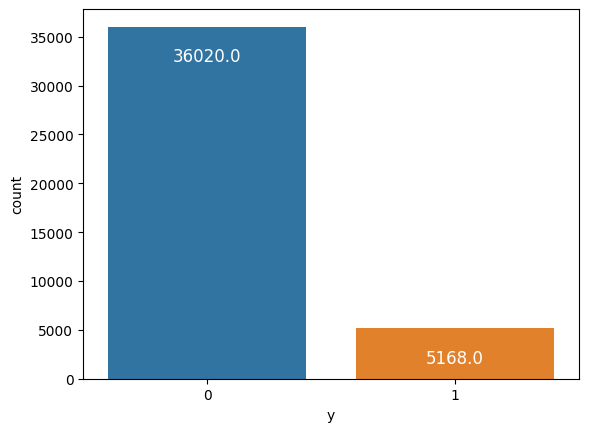

In [76]:
ax = sns.countplot(x="y", data=df, hue = "y", legend = False)
for p in ax.patches:
     ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', color='white', size=12)

## Outliers - numerical

To find outliers, I used ***statistic Z*** (z = (X - mean) / std_deviation) with the assumption that any observation with a z-score greater than 3 or less than -3 could be an outlier. I used the ***describe*** function to look at quantiles and min-max. Outliers aren’t inherently "bad", I just want to get to know more about my variables and how to make them better.

In [77]:
treshold = 3
df_quant_outliers = pd.DataFrame.from_records(
    stats.zscore(df.select_dtypes(include=np.number)),
    columns=df.select_dtypes(include=np.number).columns.tolist())

print("Number of outliers per attribute:")
print(df_quant_outliers[(df_quant_outliers > treshold) | (df_quant_outliers < -treshold)].count())
outlier_list = list(
    np.where((df_quant_outliers > treshold) | (df_quant_outliers < -treshold))[0])

Number of outliers per attribute:
age                369
duration           890
campaign           699
pdays             1515
previous          1064
emp.var.rate         0
cons.price.idx       0
cons.conf.idx        0
euribor3m            0
nr.employed          0
y                    0
dtype: int64


In [78]:
df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000,41188.00000
mean,40.02406,103.86911,1.01879,962.47545,0.17296,0.08189,0.08189,-40.50260,3.62129,5167.03591,0.12547
std,10.42125,208.23106,2.11474,186.91091,0.49490,1.57096,1.57096,4.62820,1.73445,72.25153,0.33126
min,17.00000,0.00000,0.00000,0.00000,0.00000,-3.40000,-3.40000,-50.80000,0.63400,4963.60000,0.00000
25%,32.00000,0.00000,0.00000,999.00000,0.00000,-1.80000,-1.80000,-42.70000,1.34400,5099.10000,0.00000
50%,38.00000,0.00000,0.00000,999.00000,0.00000,1.10000,1.10000,-41.80000,4.85700,5191.00000,0.00000
75%,47.00000,139.00000,1.00000,999.00000,0.00000,1.40000,1.40000,-36.40000,4.96100,5228.10000,0.00000
max,98.00000,4918.00000,43.00000,999.00000,7.00000,1.40000,1.40000,-26.90000,5.04500,5228.10000,1.00000


* ***age*** - the minimum age in the dataset is 17, while the maximum is 95. This is natural, age in a population is typically not normally distributed,
* ***pdays*** - this is the number of days since the customer was last contacted by a previous campaign (numeric; 999 means the customer has not been contacted). In this case, it can be beneficial because it highlights that it's better to contact customers who have not been contacted recently.
* ***previous*** - This is the number of contacts made before this campaign and for this customer. All quantiles are zero. This shows that most customers have never been contacted by the bank, similar to pdays.

I will look into correlations before deciding what to do with those variables. Even with limited variability, the variable might still predict the target in some cases. Two other characteristics have highly skewed distributions: campaign and duration. However, these features are not used in the model.

## Outliers - categorical

Next, I wanted to look into categorical variables. As a result, I'll join some categories, because otherwise the number of dummies introduced later would be far too large.

In [79]:
# Initialize the dictionary to hold the results
d = {'attribute': [], 'least_common_value': [], 'count': []}

# Iterate over each object column in the DataFrame
for col_name in df.select_dtypes(include='object').columns:
    # Get value counts for the column, sorted by frequency
    value_counts = df[col_name].value_counts()
    
    # Get the least common value (the last one in the sorted order)
    least_common_value = value_counts.index[-1]
    least_common_count = value_counts.iloc[-1]
    
    # Append results to the dictionary
    d['attribute'].append(col_name)
    d['least_common_value'].append(least_common_value)
    d['count'].append(least_common_count)

# Create a DataFrame from the dictionary
least_common_tab = pd.DataFrame(data=d)

# Display the result
least_common_tab

,attribute,least_common_value,count
0,job,unknown,330
1,marital,unknown,80
2,education,illiterate,18
3,default,yes,3
4,housing,unknown,990
5,loan,unknown,990
6,contact,telephone,5995
7,month,dec,78
8,day_of_week,fri,3111
9,poutcome,success,1373


In [80]:
# Joining categories 
# for this point also catplots from next section were analysed
df['credit'] = df[['loan', 'housing', 'default']].apply(lambda x: x.str.contains('yes').any(), axis=1)
df['education'] = df['education'].replace(['basic.4y','basic.6y','basic.9y',"illiterate"],'basic')
df['education'] = df['education'].replace(['basic','high.school','professional.course'],'non-graduate')
df['job'] = df['job'].replace(['student','unemployed','retired'],'unemployed')
df['job'] = df['job'].replace(['self-employed', 'entrepreneur'],'self-employed')
df['job'] = df['job'].replace(['management','admin.'],'management and admin')
df['job'] = df['job'].replace(['blue-collar','services','management job'],'office')
df['job'] = df['job'].replace(['housemaid', 'services'], 'services' )
df['marital'] = df['marital'].replace(['divorced','married',],'married/divorced')
df.drop("loan", axis='columns', inplace=True)
df.drop("housing", axis='columns', inplace=True)
df.drop("default", axis='columns', inplace=True)

## EDA - numerical

Numerical variables that have the ***correlation with target variable***:

* **emp.var.rate (corr=-0.26)** - A higher emp.var.rate often signals economic recovery or growth, leading to increased consumer confidence. In such cases, people might prioritize spending or investing in riskier assets (e.g., stocks) rather than saving in deposits and during downturns, people may turn to safer financial instruments like deposits
* **cons.price.idx (corr=-0.26)** - The negative correlation indicates that as the consumer price index increases (inflation), people are less likely to place deposits. Inflation reduces the real value of money, discouraging savings, especially if deposit rates fail to keep up with inflation. Additionally, rising living costs associated with inflation may leave people with less disposable income to allocate toward deposits
* **euribor3M (corr=-0.27)** - Euribor is called the "price of money". The fact that this correlation is negative, probably results in the fact that inflation effect on living costs is dominant in this case in comparison with higher interest rates
* **nr_employed (corr=-0.31)** - same explanation as in emp.var.rate
* **previous (corr=0.21)** - means number of contacts performed before this campaign. The correlation is positive, so we may assume there is a positive correlation between client being the subject of campaign and them making a deposit
* **duration (corr=0.21)** which won't be used in the model but indicates that the longer contact, the higher the chance for deposit


There are some attributes **highly correlated with each other**:
*  ***emp.var.rate, cons.price.idx, nr.employed, euribor3m - (corr>0.9)*** - They are all indicators of the economy's state, so their correlations are understandable. That's why later I will use ***Lasso Regression*** (which also deals with correlated features) for feature selection.

<Axes: >

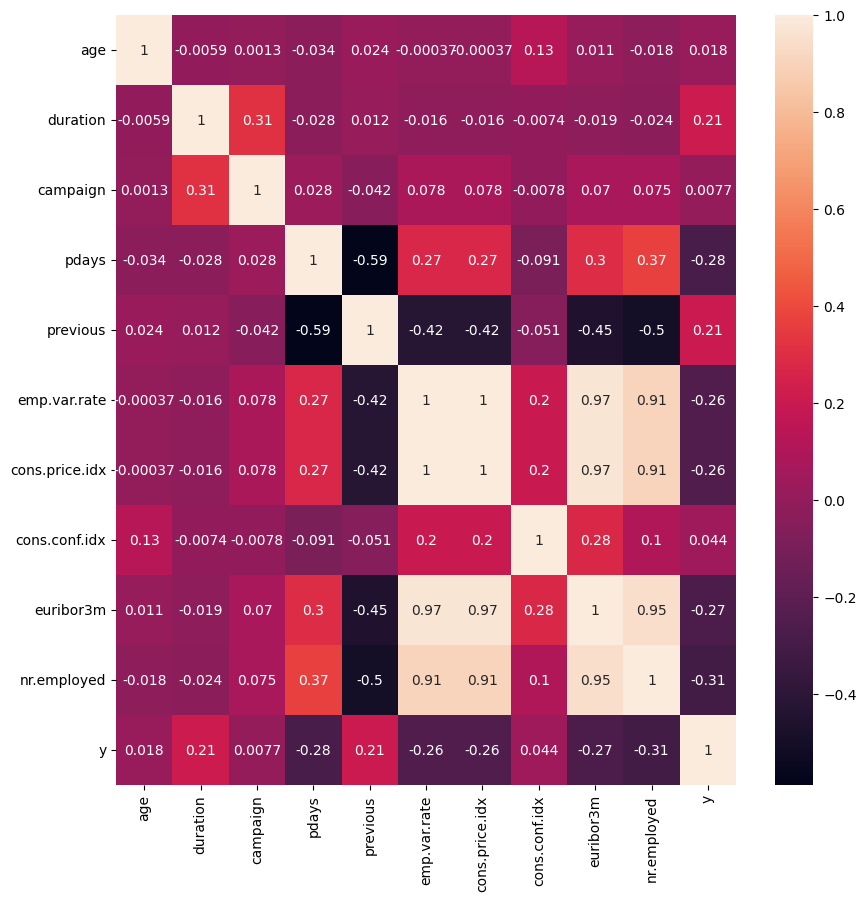

In [81]:
corr = df.select_dtypes(include=['number']).corr()
plt.figure(figsize=(10, 10), dpi=100)
sns.heatmap(corr, annot=corr)

## EDA - categorical ##

* Job - I can make the conclusion that there is visibly ***more chance for deposit subscription if clients are unemployed (students, retired or unemployed)***. The percentage of deposit subscriptions is high in these groups (between 20% and 30%). 

* Marital status - There is slightly ***more single people that made deposit***.

* Education-Clients ***with university degrees have a little more percentage of open deposits*** than other group.* Contact -

* People who were contacted by ***cellular during the campaign have put deposits more often****

* Month and day - this may be surprising but people who were contacted in ***December, March, October and September placed deposits more often***. However, there is no visible connection with the target class when it comes to day variable.

* Poutcome - ***if the previous campaign was successful, there is a higher chance of deposit subscription***. Also, if there was a failure of a previous campaign, the chance of a positive deposit subscription is higher than if there was no campaign at all.

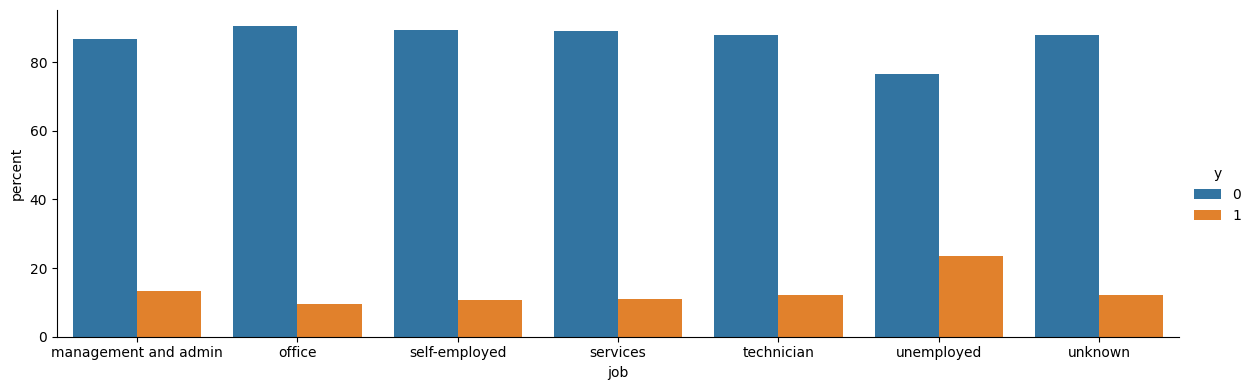

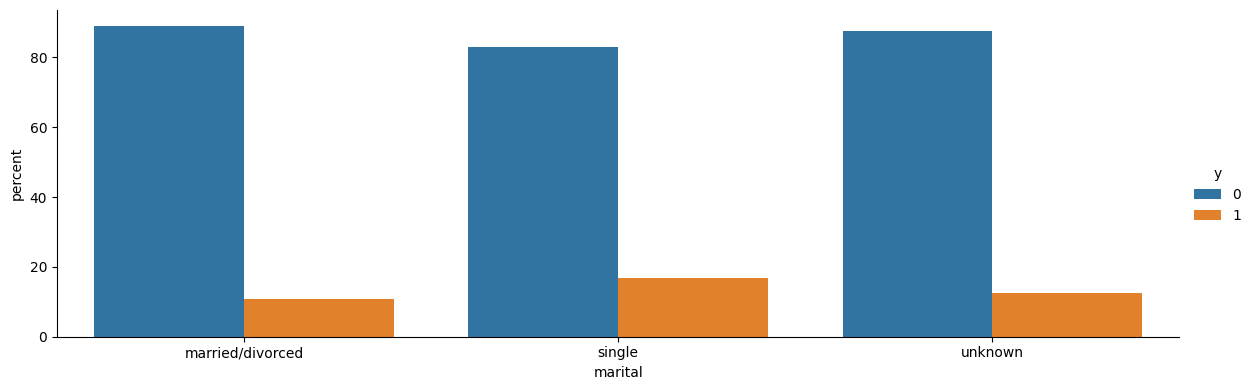

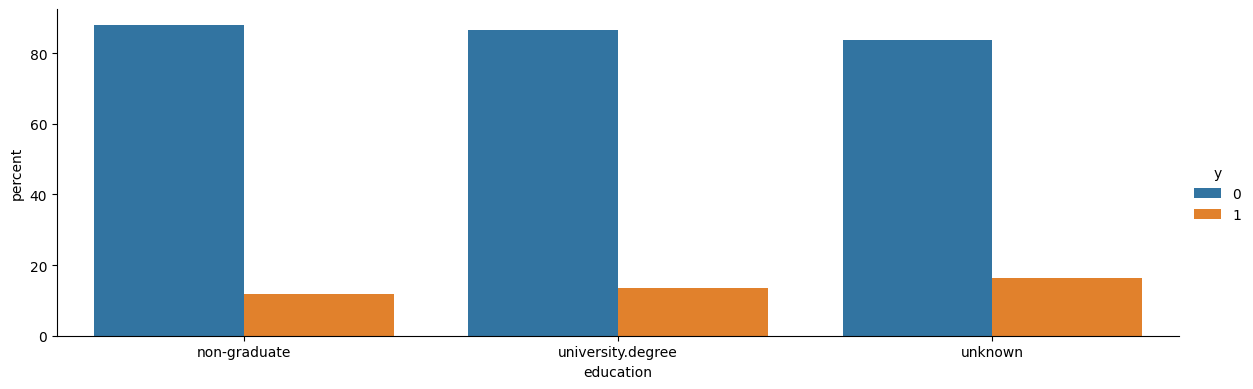

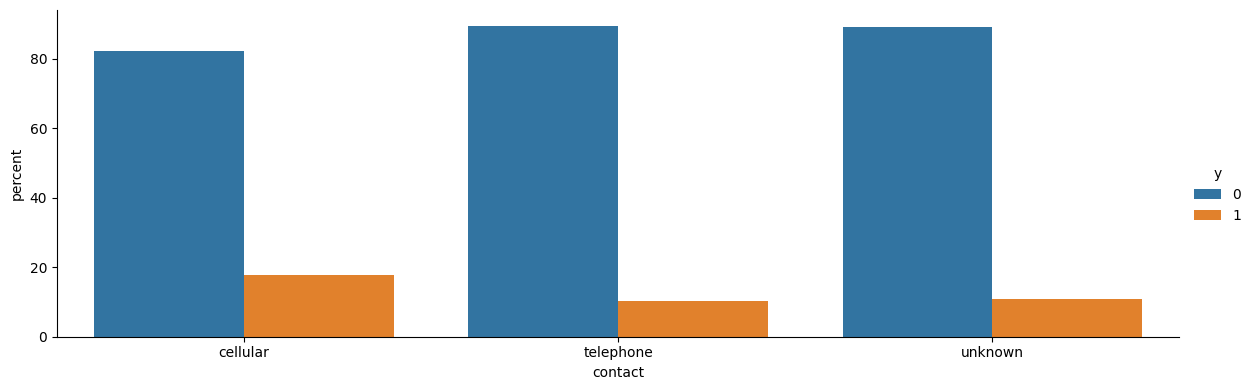

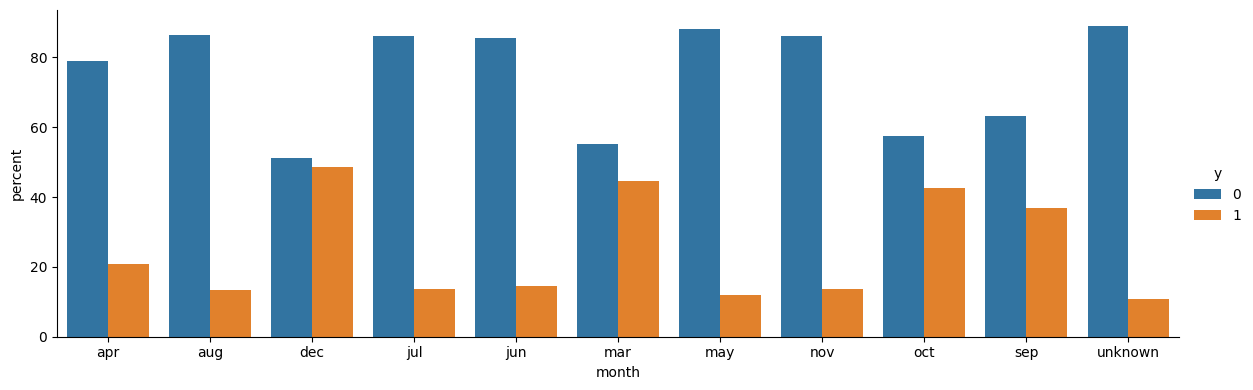

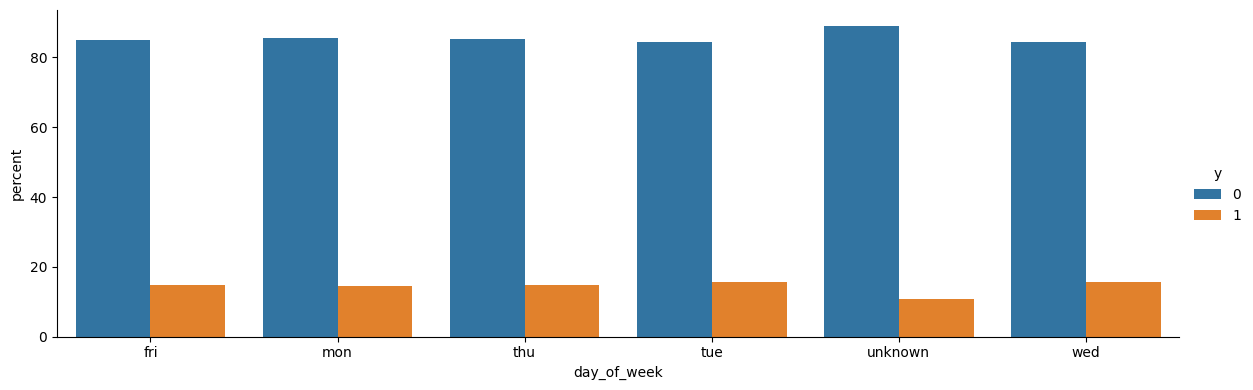

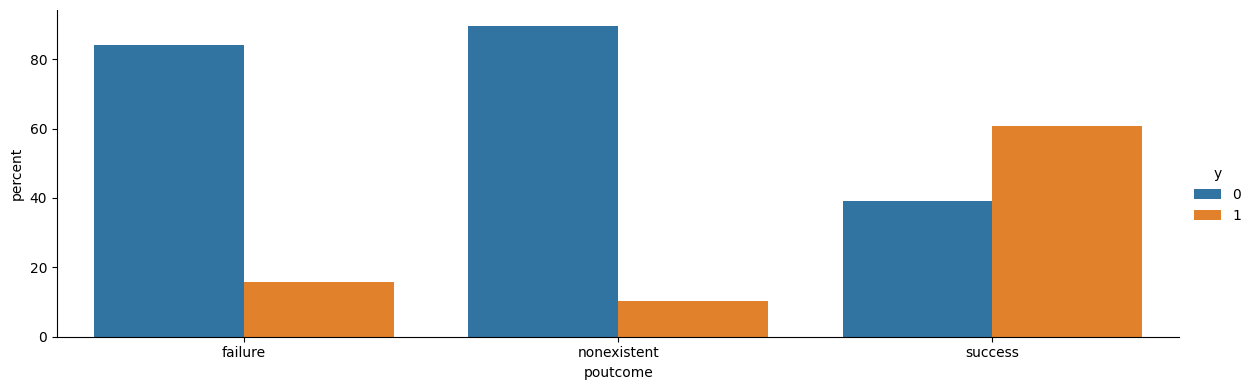

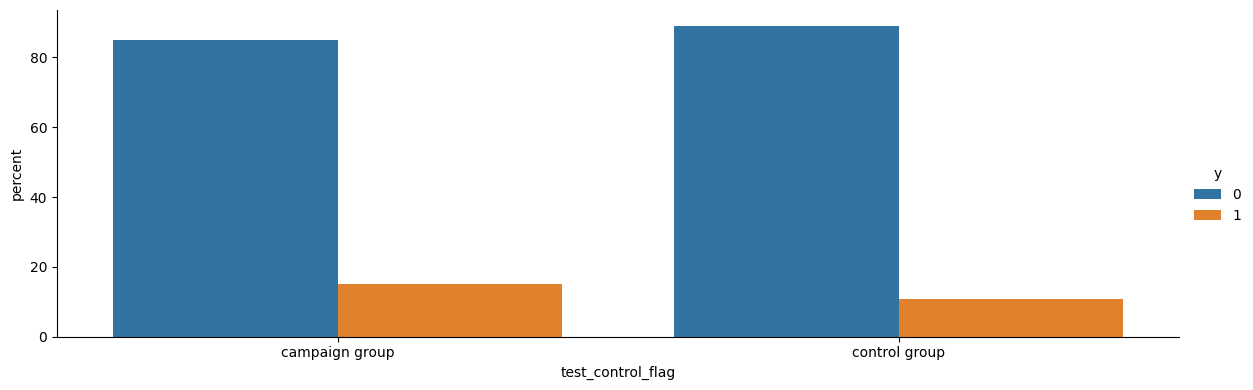

In [82]:
for col_name in df.select_dtypes(include='object').columns:
    x, y = col_name, 'y'
    show_categories_bar_chart(x, y, df)

## Droping features that cannot be used for model creation

As I said, I can only use characteristics that are not related to the current campaign (I need characteristics that are known before the campaign, so that the model will be helpful in predicting who we should contact).

In [83]:
df_for_analysis = df.drop(["test_control_flag", "day_of_week", "contact", "month", "day_of_week", "duration", "campaign"], 
                          axis='columns', inplace=False)

# Feature selection #

I use Lasso Regression, which chooses only features having an impact on the target variable. Moreover, it deals with features correlated with each other (by removing one of them). Before Lasso, I used RobustScaler, not StandardScaler, because I have a dataset with outliers.

In [84]:
df_dummies = pd.get_dummies(
    df_for_analysis[df_for_analysis.select_dtypes(include='object').columns],
    drop_first=True)
df_for_analysis = df_for_analysis.drop(columns=df_for_analysis.select_dtypes(
    include='object').columns)
df_for_analysis = pd.merge(df_for_analysis,
                           df_dummies,
                           on=df_for_analysis.index)
df_for_analysis.drop("key_0", axis='columns', inplace=True)
print("Size of dataset after dummy variables: ", len(df_for_analysis.columns))

Size of dataset after dummy variables:  22


In [85]:
scaler = RobustScaler()
X = df_for_analysis.drop("y", axis='columns', inplace=False)
y = df_for_analysis['y']
X_scaled = scaler.fit(X).transform(X)
X_scaled

lasso = Lasso(alpha=0.001)
lasso.fit(X_scaled, y)
FI_lasso = pd.DataFrame({"Feature Importance": lasso.coef_}, index=X.columns)
keep_values = []
for x in FI_lasso.sort_values("Feature Importance", ascending=False):
    if x == True:
        keep_values.append(x)

X = X[FI_lasso[FI_lasso.values != 0].index]

In [86]:
print("Variables left after feature selection:", len(X.columns))
X.columns

Variables left after feature selection: 10


Index(['age', 'pdays', 'cons.conf.idx', 'nr.employed', 'credit', 'job_office',
       'job_unemployed', 'marital_single', 'education_university.degree',
       'poutcome_nonexistent'],
      dtype='object')

# Creating few models #

The ***cost of including additional customers in the campaign (even if they do not deposit later) is likely to be lower than omitting a customer who may deposit if contacted***. So it would be best if I used a recall measure during the training. However, this is not a good metric for training, as it can lead to extreme cases where all observations are classified as positive cases. So I will use AUC as a compromise.

Models are created with features chosen by LASSO.

In [87]:
# splitting dataset according to the rule 70%-15%-15%

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    random_state=4,
                                                    stratify=y)

X_test, X_validation, y_test, y_validation = train_test_split(X_test,
                                                              y_test,
                                                              test_size=0.5,
                                                              random_state=4,
                                                              stratify=y_test)

scaler = RobustScaler()
X_train_standardized = scaler.fit_transform(X_train)
X_validation_standardized = scaler.transform(X_validation)

## Logistic Regression ##


The first algorithm used for classification was Logistic Regression. I used standardized datasets for that. The ***weights had to be actualized for imbalanced data***. I have also used ***L2 Regularization***, so the model would not increase its complexity too much.

In [88]:
model = LogisticRegression(class_weight="balanced", penalty='l2')

param_grid = {'penalty': ['l1', 'l2', 'elasticnet'],'C': [0.001, 0.01, 0.05, 0.2, 1, 3]}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

logistic = GridSearchCV(estimator=model,
                        param_grid=param_grid,
                        cv=cv,
                        scoring='roc_auc')

logistic = logistic.fit(X_train_standardized, y_train)

print("Best: %f using %s" % (logistic.best_score_, logistic.best_params_))

Best: 0.728286 using {'C': 0.2, 'penalty': 'l2'}


## Decision Tree ##

The second algorithm used for classification was Decision Tree ***checked for two splitting criteria and various maximum tree depths, number of min samples in leaf and split***.

In [89]:
model = DecisionTreeClassifier(class_weight="balanced")

param_grid = {
    'criterion': ["gini", "entropy"],
    'max_depth': [4, 6, 7, 8, 9, 12],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [10, 15]
}

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

tree = GridSearchCV(estimator=model,
                    param_grid=param_grid,
                    cv=cv,
                    scoring='roc_auc')

tree.fit(X_train, y_train)
print("Best: %f using %s" % (tree.best_score_, tree.best_params_))

tree = tree.best_estimator_

Best: 0.739918 using {'criterion': 'entropy', 'max_depth': 6, 'min_samples_leaf': 15, 'min_samples_split': 20}


## XGBoost ##

The next classifier I used was XGBoost, which was validated using different learning rates and maximum tree depths. I need to use RandomizedSearchCV because XGBoost requires too long training. ***RandomizedSearchCV randomly samples a fixed number of parameter combinations from a specified search space.***

In [90]:
learning_rates = [0.01, 0.05, 0.1]
n_estimators = [150, 200, 300, 500]
max_depth = [4, 5, 6, 8, 10, 14]

number_neg_class = y_train.value_counts()[0]
number_pos_class = y_train.value_counts()[1]

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

model = XGBClassifier(scale_pos_weight=number_neg_class / number_pos_class,
                      eval_metric="logloss")

param_grid = dict(learning_rate=learning_rates,
                  max_depth=max_depth,
                  n_estimators=n_estimators)

xgb = RandomizedSearchCV(model, param_grid, cv=cv, scoring='roc_auc', n_iter=30)
xgb.fit(X_train, y_train)

print("Best: %f using %s" % (xgb.best_score_, xgb.best_params_))
xgb = xgb.best_estimator_

Best: 0.747756 using {'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.01}


# Compare the models #

Functions to evaluate the models:

In [91]:
def print_metrics(
    classifier_name: str,
    y_true: Union[pd.Series, np.ndarray, list],
    y_pred: Union[pd.Series,np.ndarray, list],
    threshold: float
)  -> None:
    """
    Helper function to print classification metrics.

    Parameters:
    - classifier_name: Name of the classifier.
    - y_true: True labels.
    - y_pred: Predicted labels.
    """
    print(f"\n ~~~~ {classifier_name}, threshold {threshold} ~~~~")
    print(f"Accuracy: {round(metrics.accuracy_score(y_true, y_pred), 2)}")
    print(f"Recall: {round(metrics.recall_score(y_true, y_pred), 2)}")
    print(f"Precision: {round(metrics.precision_score(y_true, y_pred), 2)}")
    print(f"AUC from: {round(metrics.roc_auc_score(y_true, y_pred), 2)}")

def find_best_threshold(y_true: Union[pd.Series, np.ndarray, list], y_scores: Union[pd.Series, np.ndarray, list], plot=False):
    """
    Finds the best threshold for a binary classifier based on the ROC curve.
    
    Parameters:
    - y_true: list or array, true binary labels (0 or 1).
    - y_scores: list or array, predicted probabilities or scores.
    - plot: bool, if True, plots the ROC curve with the best threshold highlighted.

    Returns:
    - best_threshold: float, the threshold corresponding to the point closest to the top-left corner of the ROC curve.
    - fpr: float, false positive rate at the best threshold.
    - tpr: float, true positive rate at the best threshold.
    """
    # Compute ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_true, y_scores)

    # Find the best threshold based on the distance to the top-left corner
    optimal_idx = np.argmin(np.sqrt(fpr**2 + (1 - tpr)**2))
    best_threshold = thresholds[optimal_idx]

    if plot:
        # Plot the ROC curve
        plt.plot(fpr, tpr, label="ROC Curve")
        plt.scatter(fpr[optimal_idx], tpr[optimal_idx], color='red', 
                    label=f"Best Threshold: {best_threshold:.2f}")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title("ROC Curve")
        plt.legend()
        plt.grid()
        plt.show()

    return round(float(best_threshold), 4), fpr[optimal_idx], tpr[optimal_idx]

In [92]:
# Logistic
probas_val_log = logistic.predict_proba(X_validation_standardized)[:, 1]
y_hat_val_log = (probas_val_log >= 0.5).astype(bool)
y_hat_train_log = (logistic.predict_proba(X_train_standardized)[:, 1] >= 0.5).astype(bool)

# Tree
probas_val_tree= tree.predict_proba(X_validation)[:, 1]
y_hat_val_tree = (probas_val_tree >= 0.5).astype(bool)
y_hat_train_tree = (tree.predict_proba(X_train)[:, 1] >= 0.5).astype(bool)

# XGB
probas_val_xgb= xgb.predict_proba(X_validation)[:, 1]
y_hat_val_xgb = (probas_val_xgb >= 0.5).astype(bool)
y_hat_train_xgb = (xgb.predict_proba(X_train)[:, 1] >= 0.5).astype(bool)

First let's check results while maintaining 0.5 probability threshold. According to them XGB is the classifier with best accuracy.

In [93]:
print_metrics("Logistic", y_validation, y_hat_val_log, 0.5)
print_metrics("Tree", y_validation, y_hat_val_tree, 0.5)
print_metrics("XGB", y_validation, y_hat_val_xgb, 0.5)


 ~~~~ Logistic, threshold 0.5 ~~~~
Accuracy: 0.75
Recall: 0.6
Precision: 0.27
AUC from: 0.68

 ~~~~ Tree, threshold 0.5 ~~~~
Accuracy: 0.8
Recall: 0.57
Precision: 0.33
AUC from: 0.7

 ~~~~ XGB, threshold 0.5 ~~~~
Accuracy: 0.81
Recall: 0.57
Precision: 0.35
AUC from: 0.71


However, let's check if threshold manipulation won't give me better results.

In [94]:
thres_log, _, _ = find_best_threshold(y_validation, probas_val_log)
thres_tree, _, _ = find_best_threshold(y_validation, probas_val_tree)
thres_xgb, _, _ = find_best_threshold(y_validation, probas_val_xgb)

y_hat_val_log = (probas_val_log >= thres_log).astype(bool)
y_hat_val_tree = (probas_val_tree >= thres_tree).astype(bool)
y_hat_val_xgb = (probas_val_xgb >= thres_xgb).astype(bool)

print_metrics("Logistic", y_validation, y_hat_val_log, thres_log)
print_metrics("Tree", y_validation, y_hat_val_tree, thres_tree)
print_metrics("XGB", y_validation, y_hat_val_xgb, thres_xgb)


 ~~~~ Logistic, threshold 0.4895 ~~~~
Accuracy: 0.74
Recall: 0.62
Precision: 0.27
AUC from: 0.69

 ~~~~ Tree, threshold 0.4299 ~~~~
Accuracy: 0.76
Recall: 0.6
Precision: 0.29
AUC from: 0.69

 ~~~~ XGB, threshold 0.4258 ~~~~
Accuracy: 0.7
Recall: 0.68
Precision: 0.25
AUC from: 0.69


Although the tree model is the most accurate, I will still choose the XGB model because it has the highest recall for the same AUC score. The reason for this will be explained later.

# Analyse the model #

In [95]:
def plot_confusion_matrix(conf_matrix: np.ndarray,
                          class_names: List[int],
                          title: str,
                          cmap: plt.cm = plt.cm.Blues) -> None:
    """
    Helper function to plot the confusion matrix.

    Parameters:
    - conf_matrix: Confusion matrix as a 2D numpy array.
    - class_names: List of class names (e.g., [0, 1]).
    - title: The title for the confusion matrix plot.
    - cmap: The color map to use for plotting.
    """
    norm_cm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    plt.imshow(norm_cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=90)
    plt.yticks(tick_marks, class_names)

    fmt = '.2f'
    thresh = norm_cm.max() / 2

    for i, j in itertools.product(range(norm_cm.shape[0]), range(norm_cm.shape[1])):
        plt.text(j, i, format(norm_cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if norm_cm[i, j] > thresh else "black")

    plt.ylabel('True values')
    plt.xlabel('Predicted values')


def show_ROC_plot(label: str, pos_probs: np.ndarray, y_test: np.ndarray, threshold: float = 0.5) -> None:
    """
    Function to plot the ROC curve with an option to choose a specific threshold.
    
    Parameters:
    - label: Name of the model to label the curve.
    - pos_probs: Array of predicted probabilities for the positive class.
    - y_test: True labels for the test data.
    - threshold: The threshold for classification (default is 0.5).
    """
    
    # Calculate False Positive Rate (FPR) and True Positive Rate (TPR)
    fpr, tpr, thresholds_roc = metrics.roc_curve(y_test, pos_probs)

    # Plot the ROC curve
    plt.plot(fpr, tpr, marker='.', label=label)
    
    # Plot the No Skill line (diagonal)
    plt.plot([0, 1], [0, 1], linestyle='--', label='No Skill')
    
    # Plot the Perfect classifier line
    plt.plot([0, 0, 1], [0, 1, 1], linestyle='--', label='Perfect')

    # Find the closest threshold to the given threshold
    closest_idx = np.argmin(np.abs(thresholds_roc - threshold))
    
    # Get FPR and TPR at the chosen threshold
    chosen_fpr = fpr[closest_idx]
    chosen_tpr = tpr[closest_idx]
    
    # Plot the chosen threshold on the ROC curve
    plt.scatter(chosen_fpr, chosen_tpr, color='red', label=f"Threshold = {threshold:.2f}", zorder=5)
    plt.annotate(f'Threshold: {threshold:.2f}', 
                 (chosen_fpr, chosen_tpr), 
                 textcoords="offset points", 
                 xytext=(0, 10), ha='center', color='red')
    
    # Customize plot
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("ROC Curve")
    plt.legend()

def find_threshold_for_recall(y_test: np.ndarray, pos_probs: np.ndarray, target_recall: float = 0.80) -> float:
    """
    Function to find the threshold that gives a specific recall value (default 80%).
    
    Parameters:
    - y_test: True labels for the test data.
    - pos_probs: Predicted probabilities for the positive class.
    - target_recall: Desired recall value (default 80%).
    
    Returns:
    - threshold: The probability threshold that gives the target recall.
    """
    # Calculate False Positive Rate (FPR), True Positive Rate (TPR), and thresholds
    fpr, tpr, thresholds = metrics.roc_curve(y_test, pos_probs)
    
    # Find the recall closest to the target_recall
    recall_diff = np.abs(tpr - target_recall)
    
    # Find the index of the threshold with recall closest to 80%
    best_threshold_index = np.argmin(recall_diff)
    
    # Return the threshold value that corresponds to the desired recall
    best_threshold = round(float(thresholds[best_threshold_index]), 4)
    
    print(f"Threshold for {target_recall*100}% recall: {best_threshold:.4f}")
    return best_threshold

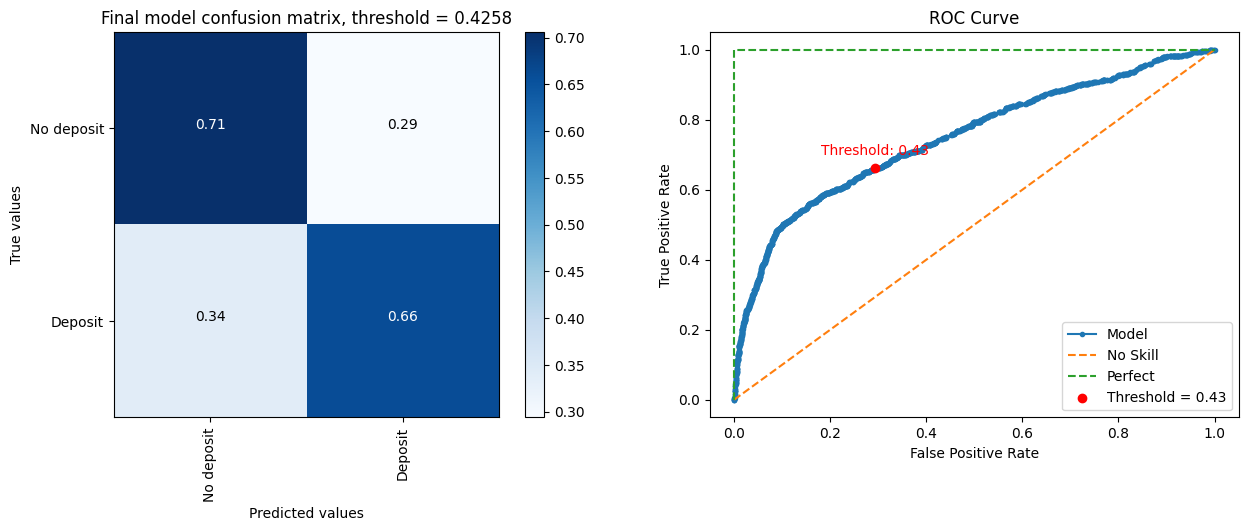

In [96]:
final_model = xgb

plt.subplots(1, 2, figsize=(15, 5))

probas_test = final_model.predict_proba(X_test)[:, 1]
y_hat_test = (probas_test >= thres_xgb).astype(bool)
cm = metrics.confusion_matrix(y_test, y_hat_test)
plt.subplot(1, 2, 1)
plot_confusion_matrix(cm, ["No deposit", "Deposit"], f"Final model confusion matrix, threshold = {thres_xgb}")
plt.subplot(1, 2, 2)
show_ROC_plot("Model", probas_test, y_test, thres_xgb)
plt.show()

In [97]:
print_metrics("Final model", y_test, y_hat_test, thres_xgb)


 ~~~~ Final model, threshold 0.4258 ~~~~
Accuracy: 0.7
Recall: 0.66
Precision: 0.24
AUC from: 0.68


The model correctly **identified 66% of people who made a deposit and 71% of those who didn't**. However, the model is more focused on predicting the positive class, as **only 24% of the positive cases detected by the model were actually positive**. Detecting positive cases is crucial if **we want to target our campaign to people who are at least likely to deposit. Including more people in the campaign is not so costly**, and omitting those who may deposit after the campaign is worse.

# Can we improve the campaign? #
The plots above are just statistical facts. What matters is if the models will improve the business situation. Let's change the statistics into some actual numbers.

As specified at the beginning of the notebook, **percentage of clients who placed a deposit was 15.08 % of clients from the campaign group** (2484 from 16476) and **10.86 % from control group** (2684 from 24712). In general, **40% of clients were included in the campaign**.

And how would those statistics possible]y look like if we used the model to choose people included in the campaign?

In [102]:
def show_lift_plot(pos_probs: np.ndarray, y_test: np.ndarray) -> None:
    """
    Function to plot the lift curve (cumulative gain).
    
    Parameters:
    - pos_probs: Array of predicted probabilities for the positive class.
    - y_test: True labels for the test data.
    """
    # Sort predicted probabilities in descending order
    order = np.argsort(pos_probs)[::-1]
    y_test_sorted = y_test[order]
    pos_probs_sorted = pos_probs[order]

    # Calculate the cumulative gains
    cumulative_gains = np.cumsum(y_test_sorted) / np.sum(y_test_sorted)
    
    # Plot the lift curve
    plt.plot(np.arange(1, len(y_test_sorted) + 1) / len(y_test_sorted), cumulative_gains, label='Lift Curve')

    # Plot the baseline (random model)
    plt.plot([0, 1], [0, 1], linestyle='--', label='Random Model')
    
    # Customize plot
    plt.xlabel('Fraction of Samples')
    plt.ylabel('Cumulative Gain')
    plt.title("Lift Curve")
    plt.legend()

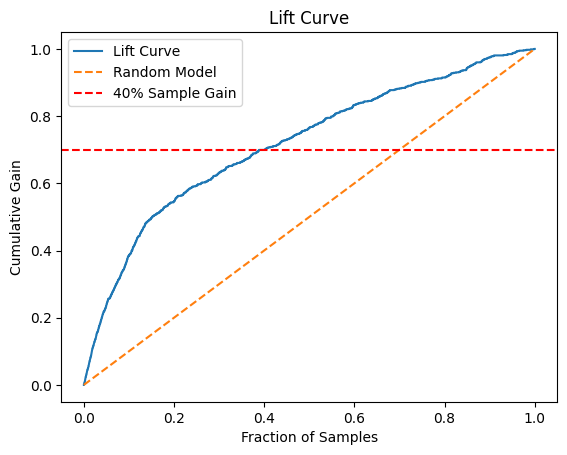

In [107]:
show_lift_plot(probas_test, y_test.values)
plt.axhline(y=0.7, color='red', linestyle='--', label='40% Sample Gain')
plt.legend()
plt.show()

Although the model is rather mediocre (only 70% accuracy), it effectively identifies the majority of true positives in the initial percentage of data. According to the LIFT curve, if a company wants to select only **40% of the most likely customers, it will identify 70% of the potentially interested people, instead of 15% with random selection**. Of course, this does not take into account the negative effect of the campaign, which may discourage customers who would have made the deposit anyway, as my model is based on the entire dataset, including customers who made deposits without being contacted.


However, this notebook demonstrates that, with the right interpretation, even a mediocre model can bring profits to the business.